# ML WORKFLOW: Canadian Housing Dataset  
Baseline predictive model using Linear Regression.

## 1. LOAD dataset with log-transformed price  
- Source: `Cleaned_HouseListings_with_log_price.csv`   
- Dataset has been cleaned and preprocessed in prior steps

In [23]:
# Import basic libraries for data handling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load preprocessed dataset with 'log_price' already included
data = pd.read_csv("Cleaned_HouseListings_with_log_price.csv")

# Preview relevant features including the log-transformed target
data[["Number_Beds", "Number_Baths", "Price", "log_price"]].head()

,Number_Beds,Number_Baths,Price,log_price
0,3,2,779900.0,5.892039
1,3,1,799999.0,5.903089
2,2,2,799900.0,5.903036
3,4,2,1200000.0,6.079181
4,1,1,668800.0,5.825296


## 2. Focus on Selected Provinces (ON, BC & AB)

To build a regionally focused model while maintaining diversity, we limit the dataset to three key provinces:

- **Ontario (ON)** and **British Columbia (BC)**: Highest average housing prices and the largest number of listings.
- **Alberta (AB)**: A mid-range province in terms of pricing and listings, offering valuable contrast.

This balanced selection improves model generalizability across different housing market conditions in Canada.

We also encode the `Province` column as a numeric feature to use it in modeling:
- `ON` → 0
- `BC` → 1
- `AB` → 2

In [24]:
# Filter dataset to include only Ontario (ON), British Columbia (BC), and Alberta (AB)
ml_data = data[data["Province"].isin(["ON", "BC", "AB"])].copy()

# Encode provinces numerically: ON = 0, BC = 1, AB = 2
province_map = {"ON": 0, "BC": 1, "AB": 2}
ml_data["Province_encoded"] = ml_data["Province"].map(province_map)

# Confirm filtering
print("Provinces included:", ml_data["Province"].unique())
print("Filtered dataset shape:", ml_data.shape)

Provinces included: ['ON' 'BC' 'AB']
Filtered dataset shape: (28432, 11)


## 3. Split the Dataset for Model Training and Evaluation (Testing)

To evaluate model performance, we split the dataset into two subsets:

- **Training set (80%)**: used to train the model.
- **Test set (20%)**: used to evaluate how well the model generalizes to unseen data.

We will predict `log_price` using the following features:
- `Number_Beds` and `Number_Baths`: core property characteristics.
- `Latitude`: captures geographic location.
- `Province_encoded`: numeric representation of the province (ON=0, BC=1, AB=2).

In [27]:
from sklearn.model_selection import train_test_split

# Define input features (X) and target variable (y)
X = ml_data[["Number_Beds", "Number_Baths", "Latitude", "Province_encoded"]] # Features
y = ml_data["log_price"] # Target (log-transformed price)

# Split dataset: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shape of split sets
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (22745, 4)
Test set size: (5687, 4)


## 4. Train a Baseline Linear Regression Model

We begin by training a **Linear Regression** model to establish a performance baseline.

### Why Linear Regression?
- Simple and interpretable baseline.
- Good for spotting linear patterns or feature issues.
- Quick diagnostic before trying complex models.

We evaluate performance using:

- **R²**: Proportion of variance explained (higher = better).
- **RMSE**: Average prediction error in log-scale (lower = better).

These two metrics give both relative fit (R²) and absolute error (RMSE).

In [28]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression       # Linear regression model
from sklearn.metrics import mean_squared_error, r2_score  # Evaluation metrics
import numpy as np                                       # Numerical operations for RMSE


# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)  # Train the model on the training set

# Predict on the test set
y_pred = lr_model.predict(X_test)  # Predict house prices (log scale)

# Evaluate performance using R² and RMSE
r2 = r2_score(y_test, y_pred)  # How well predictions explain variance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Average prediction error in log10 scale

# Print evaluation results
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

R-squared (R²): 0.3665
Root Mean Squared Error (RMSE): 0.2321


## 5. Visualize Predictions: Actual vs. Predicted (Log Scale)

This scatter plot compares the model’s predicted `log_price` values with the actual values from the test set.

- Points along the diagonal line represent **perfect predictions**.
- Deviations from this line indicate **prediction errors**.
- This plot helps visually assess how well the linear model generalizes to new, unseen data.

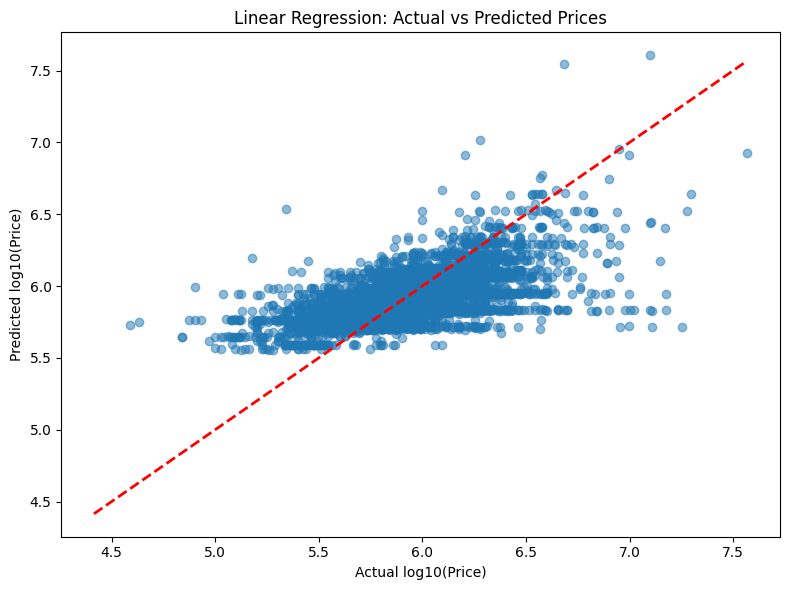

In [29]:
import matplotlib.pyplot as plt  # Library for plotting

# Scatter plot: Predicted vs Actual values
plt.figure(figsize=(8, 6))  # Set figure size

# Plot the predicted vs actual values
plt.scatter(y_test, y_pred, alpha=0.5)  # Semi-transparent points for better readability

# Add reference diagonal line for perfect predictions
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)  # Red dashed line

# Add axis labels and plot title
plt.xlabel("Actual log10(Price)")       # x-axis label
plt.ylabel("Predicted log10(Price)")    # y-axis label
plt.title("Linear Regression: Actual vs Predicted Prices")  # Title

# Improve layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

### Interpretation: Actual vs Predicted Plot

This scatter plot compares the **actual log-transformed house prices** (on the x-axis) against the **predicted prices** from the Linear Regression model (on the y-axis).

- The **red dashed line** represents the ideal scenario where predictions are perfectly accurate (`y = x`).
- Points that fall **close to the red line** are well predicted.
- Points **far from the line** indicate prediction errors.

In our plot, we observe some spread around the line, especially for higher price ranges.  
This confirms that the model captures general trends, but also **misses some patterns**, especially at the extremes.  
This is typical of linear models when the data contains **non-linear relationships or complex interactions**.

### Residual Plot: Error Analysis

The residual plot helps evaluate how well the Linear Regression model fits the data by visualizing the prediction **errors** (residuals).

- A **residual** is the difference between the actual value and the predicted value.
- Ideally, residuals should be **randomly scattered around zero** — this suggests a good fit.
- **Patterns or curves** in the residuals may indicate that the model is missing important relationships or that a non-linear model may be more appropriate.

This diagnostic is useful to assess if Linear Regression assumptions hold or if a more advanced model is needed.


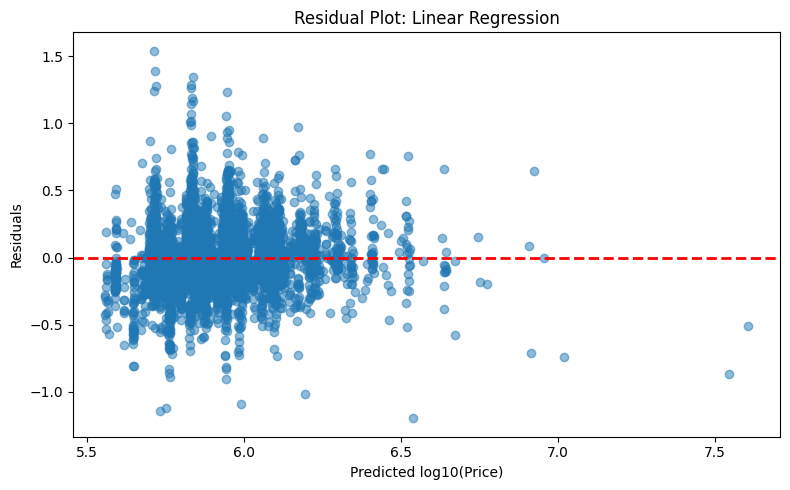

In [30]:
import matplotlib.pyplot as plt

# Compute residuals: actual - predicted
residuals = y_test - y_pred

# Plot residuals vs. predicted values
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Reference line at zero
plt.xlabel("Predicted log10(Price)")
plt.ylabel("Residuals")
plt.title("Residual Plot: Linear Regression")
plt.tight_layout()
plt.show()

### Residual Plot Interpretation

The residual plot helps assess how well the linear regression model fits the data:

- Most residuals are tightly clustered around 0, indicating good predictions for many listings.
- The spread of errors increases as predicted prices grow, meaning the model struggles with more expensive homes.
- This widening pattern suggests the model may not fully capture complex price behavior at higher values.
- A few large residuals (outliers) may further distort the model’s accuracy.

This pattern confirms that a more flexible model may improve accuracy by capturing non-linear effects and handling outliers better.

## 6. Simulate a Real Prediction

Now that the linear regression model has been trained, we can simulate a prediction for a new house listing.

This helps demonstrate how the model uses specific features (beds, baths, latitude, province) to estimate housing prices.

The prediction will output the log10(Price) and also convert it back to the actual price.

In [36]:
ml_data[["Number_Beds", "Number_Baths"]].value_counts().head(5)

Number_Beds  Number_Baths
2            2               4150
3            2               3205
             3               3065
1            1               2478
4            3               2341
Name: count, dtype: int64

In [37]:
# Compute average latitude per province (ON, BC, AB)
avg_latitudes = ml_data.groupby("Province")["Latitude"].mean().round(2)

# Define new listings with identical features, varying only by province
new_listings = pd.DataFrame({
    "Number_Beds": [2, 2, 2],
    "Number_Baths": [2, 2, 2],
    "Latitude": [
        avg_latitudes["ON"],
        avg_latitudes["BC"],
        avg_latitudes["AB"]
    ],
    "Province_encoded": [0, 1, 2]  # ON = 0, BC = 1, AB = 2
})

# Make predictions
predicted_log_prices = lr_model.predict(new_listings)
predicted_prices = 10 ** predicted_log_prices

# Display formatted results
provinces = ["Ontario (ON)", "British Columbia (BC)", "Alberta (AB)"]

# Dynamically generate title based on feature values
beds = new_listings["Number_Beds"].iloc[0]
baths = new_listings["Number_Baths"].iloc[0]
print(f"Predicted House Prices for a {beds} Bed / {baths} Bath home:\n")
for prov, log_p, p in zip(provinces, predicted_log_prices, predicted_prices):
    print(f"{prov:<25} → log10(Price): {log_p:.4f} | Price: ${p:,.0f}")

Predicted House Prices for a 2 Bed / 2 Bath home:

Ontario (ON)              → log10(Price): 5.8760 | Price: $751,684
British Columbia (BC)     → log10(Price): 5.8347 | Price: $683,443
Alberta (AB)              → log10(Price): 5.7210 | Price: $526,065


### Interpretation of Predicted Prices (2 Bed / 2 Bath)

The table above shows predicted house prices for a typical 2-bedroom, 2-bathroom home across the selected provinces.

This configuration was chosen because it is the most common in the dataset, ensuring reliable and data-driven predictions.

### Observations:
- **Ontario (ON)** has the highest predicted price (~\$751K), consistent with its dominant market size and urban centers like Toronto.
- **British Columbia (BC)** follows closely (~\$683K), reflecting high property values in areas like Vancouver.
- **Alberta (AB)** shows a notably lower price (~\$526K), aligning with its generally more affordable housing market.

These predictions match market expectations and reflect the influence of location, even with the same house features.  
This supports the model's ability to learn and differentiate based on geographic and spatial patterns.